## import des librairies & chargement des dataset

In [574]:
import os.path

import pandas as pd
import seaborn as sns


In [575]:
FD_wIP = "./Fraud_Data_wIP.csv"


if os.path.isfile(FD_wIP):
    fd = pd.read_csv(FD_wIP)
    build_it = 0

else:
    fd = pd.read_csv("Fraud_Data.csv")
    geoip = pd.read_csv("IpAddress_to_Country.csv")
    build_it = 1


In [576]:
if not build_it :
    print("dataset with countries found and loaded from file.")
else:
    print("dataset with countries not found, now building it...")

dataset with countries found and loaded from file.


## Ajout des pays, via les addresses IP du dataset geoip.

In [577]:
if build_it :

        fd.ip_address = fd.ip_address.astype(float)

        # 
        # on va construire une liste de paires (index, pays)
        # puis joindre avec le dataset d'origine
        # 

        row_list = []

        # un itérateur pour chaque table
        geoip_gen = geoip.iterrows()
        fds_gen = fd.sort_values(by='ip_address').iterrows()

        # une fonction pour itérer sur la table fraud 
        def next_ip(g):
                i_fds, row_fds = next(g)
                ip = row_fds['ip_address']
                return i_fds, ip

        # initialisation
        l, u, c = tuple(next(geoip_gen)[1])
        i_fds, ip = next_ip(fds_gen)

        # parcours et identification du pays
        while(True):
                try:
                        if ip < l:                
                                i_fds, ip = next_ip(fds_gen)
                        
                        elif l <= ip <= u:
                                row_list.append((i_fds, c))
                                i_fds, ip = next_ip(fds_gen)
                        
                        elif ip > u:
                                l, u, c = tuple(next(geoip_gen)[1])
                
                except Exception as e :
                        break        


        pivot = pd.DataFrame(row_list, columns=['index', 'country'])
        pivot.set_index('index', inplace=True)

        # le resultat = notre dataset avec une colonne country en plus
        fd = fd.join(pivot)
        fd.to_csv("Fraud_Data_wIP.csv")

        # free memory
        del(geoip)
        del(row_list)

## cleaning, fillna, cast dates  

In [578]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      151112 non-null  int64  
 1   user_id         151112 non-null  int64  
 2   signup_time     151112 non-null  object 
 3   purchase_time   151112 non-null  object 
 4   purchase_value  151112 non-null  int64  
 5   device_id       151112 non-null  object 
 6   source          151112 non-null  object 
 7   browser         151112 non-null  object 
 8   sex             151112 non-null  object 
 9   age             151112 non-null  int64  
 10  ip_address      151112 non-null  float64
 11  class           151112 non-null  int64  
 12  country         129146 non-null  object 
dtypes: float64(1), int64(5), object(7)
memory usage: 15.0+ MB


In [579]:
# un nouvel user_id à chaque observation, cette variable n'apporte pas d'information 

fd.user_id.value_counts().max()

1

In [580]:
# remove columns with no useful information

todrop = ['user_id', 'Unnamed: 0']
fd.drop(todrop, axis=1, inplace=True)

In [581]:
# cast the columns with dates to datetime

fd.signup_time = pd.to_datetime(fd.signup_time)
fd.purchase_time = pd.to_datetime(fd.purchase_time)

In [582]:
# replace NaN in country
fd.country.fillna(value='n.a.', inplace=True)


In [583]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   signup_time     151112 non-null  datetime64[ns]
 1   purchase_time   151112 non-null  datetime64[ns]
 2   purchase_value  151112 non-null  int64         
 3   device_id       151112 non-null  object        
 4   source          151112 non-null  object        
 5   browser         151112 non-null  object        
 6   sex             151112 non-null  object        
 7   age             151112 non-null  int64         
 8   ip_address      151112 non-null  float64       
 9   class           151112 non-null  int64         
 10  country         151112 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 12.7+ MB


## exploration, feature eng. 

### Feature : device_id

certain device_id sont réutilisé plusieurs fois ?



In [584]:
# feature engineering => add a column (device_id_new) with 'Y'/'N' if the device_id is a new one (never seen before)

# device id usage
did = fd.device_id.value_counts()

#did[did > 1].reset_index().groupby('device_id').count()

did[did>1] = 0
did[did==1] = 1

fd = fd.join(did, on='device_id', rsuffix="_did")
fd.rename(columns={'device_id_did': 'device_id_new'}, inplace=True)

del(did)


In [585]:
# il y a une corrélation forte entre le fait que le device_id_new et la classe 
fd.corr()

,purchase_value,age,ip_address,class,device_id_new
purchase_value,1.000000,0.002370,-0.000328,0.001011,-0.000927
age,0.002370,1.000000,0.001140,0.006624,-0.007796
ip_address,-0.000328,0.001140,1.000000,-0.005208,0.002253
class,0.001011,0.006624,-0.005208,1.000000,-0.566548
device_id_new,-0.000927,-0.007796,0.002253,-0.566548,1.000000


### Feature : age

- faire des classes d'age
- voir les caractéristiques (moyennes ?) par classe d'age (purchase value et autres)


In [586]:

def age_classe(a, r=5, maxi=55, mini=20):
    if int(a) > maxi :
        return str(maxi+1) + '+'
    elif int(a) < mini :
        return '-' + str(mini)
    else:
        return str(r * (a//r)) + '-' + str(min(r * (a//r) + r - 1, maxi))

#fd['age_group'] = fd.age.apply(lambda x : age_classe(x, maxi=54))

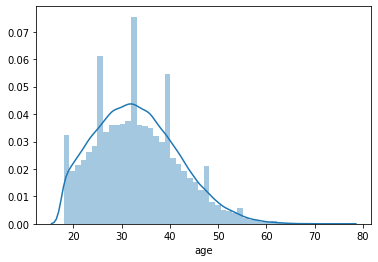

In [587]:
_ = sns.distplot(fd.age)

In [588]:
fd.groupby(['age_group'])['purchase_value', 'class'].mean()

KeyError: 'age_group'

In [589]:
fd.groupby(['country', 'age_group'])['purchase_value'].mean().reset_index()


KeyError: 'age_group'

### frequence des achats (ou delta avec le dernier achat)

In [590]:

# resample purchases to get a frequency of purchases, then by country, and/or hour, -> detect fraudulent activities



In [591]:
## add day name
#fd['purchase_day'] = fd.purchase_time.apply(lambda x: x.day_name())

## add delta in sec. with signup time
fd['delta_sec'] = (fd.purchase_time - fd.signup_time).apply(lambda x : (x.days * 86400) + x.seconds)

In [592]:
fd[(fd['class']==1) & (fd['purchase_time'] < '13-01-2015')].set_index('purchase_time').sort_index()
# etrange ... probablement des tests. a virer pour ne pas polluer le modèle ?

## drop all samples before 14.01.2015, as they seem to be mostly tests with class=1
fd.drop(fd[fd['purchase_time'] < '14-01-2015'].index, inplace=True)


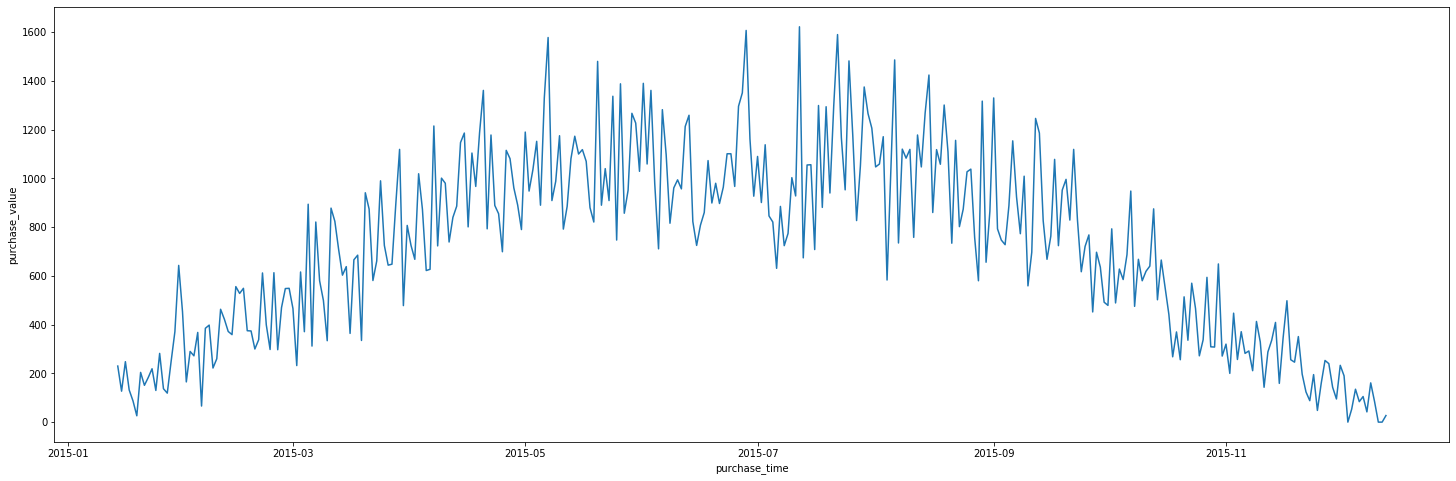

In [593]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[(fd['class']==1)].set_index('purchase_time').resample('1d').sum()
_ = sns.lineplot(x=tmp.index, y='purchase_value', data=tmp)

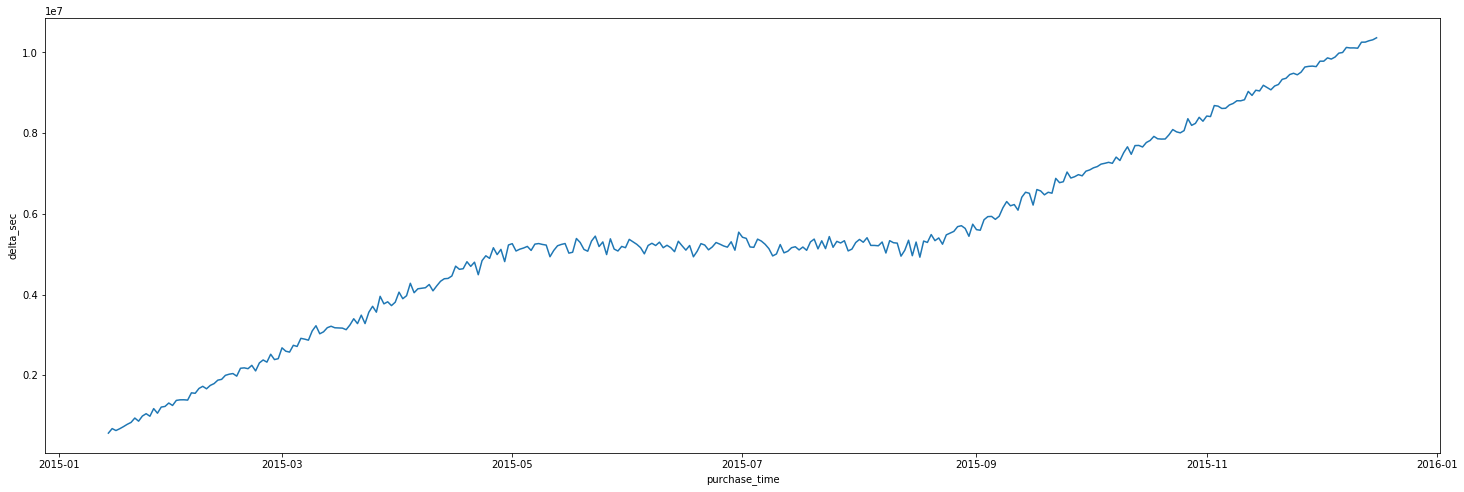

In [594]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[fd['class']==0].set_index('purchase_time').resample('1d').mean()
_ = sns.lineplot(x=tmp.index, y='delta_sec', data=tmp)

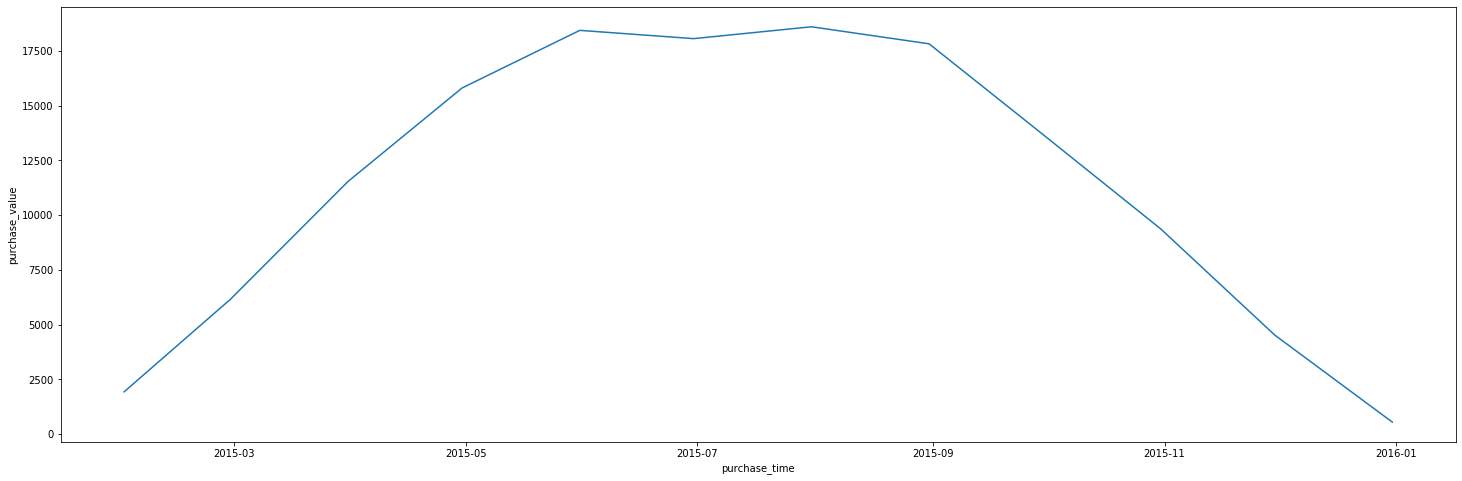

In [595]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))

tmp = fd[fd['class']==0].set_index('purchase_time').resample('1m').count().reset_index()

_ = sns.lineplot(x='purchase_time', y='purchase_value', data=tmp)


### source, browser, sex

voir si ces features ont un interet pour notre prédiction de classe


In [596]:
fd.groupby('sex').mean()

,purchase_value,age,ip_address,class,device_id_new,delta_sec
sex,,,,,,
F,36.914758,33.092321,2.149136e+09,0.045162,0.918500,5.216875e+06
M,36.956244,33.139214,2.155524e+09,0.046009,0.918636,5.203183e+06


In [597]:
fd.groupby('source').mean()

# ==> source Direct a quelques fraudeur de plus...

,purchase_value,age,ip_address,class,device_id_new,delta_sec
source,,,,,,
Ads,36.953579,33.130304,2.154605e+09,0.044040,0.917740,5.196383e+06
Direct,36.915812,33.157051,2.165484e+09,0.054267,0.919587,5.218077e+06
SEO,36.936161,33.090408,2.144800e+09,0.042925,0.918901,5.216609e+06


In [598]:
fd.groupby('browser').mean()
# non 

,purchase_value,age,ip_address,class,device_id_new,delta_sec
browser,,,,,,
Chrome,37.008891,33.099083,2.155532e+09,0.045494,0.918941,5.191166e+06
FireFox,36.931878,33.104440,2.147978e+09,0.045558,0.918554,5.218861e+06
IE,36.782119,33.144359,2.157496e+09,0.045358,0.919509,5.201682e+06
Opera,36.621074,32.837521,2.152382e+09,0.045688,0.911765,5.207022e+06
Safari,37.055162,33.190809,2.144282e+09,0.046594,0.917342,5.253707e+06


### country

- pays important vs non-importants 

- tendances / spécifiques par pays ?

- frequence d'achat et purchase_value moyenne par pays ?





In [599]:
ctry_mean = fd.groupby('country').mean().sort_values(by='class', ascending=False).reset_index()
ctry_mean[:15]

## connot use that data to predict class.

,country,purchase_value,age,ip_address,class,device_id_new,delta_sec
0,Turkmenistan,37.000000,29.000000,1.583788e+09,1.000000,0.000000,2.756012e+06
1,Virgin Islands (U.S.),43.333333,29.333333,2.105951e+09,0.333333,1.000000,3.993639e+06
2,Uzbekistan,38.100000,33.600000,1.913283e+09,0.200000,0.800000,5.803732e+06
3,Malta,34.454545,28.863636,1.516991e+09,0.181818,0.863636,5.153833e+06
4,Afghanistan,32.333333,32.000000,3.043937e+09,0.166667,0.833333,3.776762e+06
5,Cote D'ivoire,20.833333,41.833333,2.109433e+09,0.166667,1.000000,3.726262e+06
6,Malawi,34.428571,31.285714,1.379114e+09,0.142857,1.000000,4.663919e+06
7,Montenegro,26.571429,30.857143,2.443286e+09,0.142857,1.000000,2.818305e+06
8,Armenia,42.714286,32.500000,2.357103e+09,0.142857,0.857143,5.223608e+06
9,Honduras,45.111111,32.444444,3.213049e+09,0.111111,0.777778,4.504766e+06


In [600]:
ctry_cnt = fd.country.value_counts()

In [601]:
def country_classifier(c):
    
    if c == 'n.a.':
            return 'n.a.'
     
    if ctry_cnt[c] == 1: 
        return 'single'
    else:
        return c



In [602]:
fd['country_group'] = fd.country.apply(lambda x : country_classifier(x))

In [603]:
fd.groupby('country_group').mean()

,purchase_value,age,ip_address,class,device_id_new,delta_sec
country_group,,,,,,
Afghanistan,32.333333,32.000000,3.043937e+09,0.166667,0.833333,3.776762e+06
Albania,29.153846,31.153846,1.447828e+09,0.000000,0.846154,5.654500e+06
Algeria,36.541667,33.241667,1.988545e+09,0.108333,0.883333,5.597419e+06
Angola,34.833333,35.125000,2.216465e+09,0.041667,0.833333,5.653879e+06
Antigua and Barbuda,31.666667,37.333333,1.240538e+09,0.000000,1.000000,3.784900e+06
...,...,...,...,...,...,...
Virgin Islands (U.S.),43.333333,29.333333,2.105951e+09,0.333333,1.000000,3.993639e+06
Zambia,34.200000,33.100000,2.530206e+09,0.000000,1.000000,4.991848e+06
Zimbabwe,38.000000,28.000000,3.300167e+09,0.000000,0.833333,6.137778e+06


In [604]:
# remove columns with no useful information

todrop = ['signup_time', 'device_id', 'ip_address', 'country']
fd.drop(todrop, axis=1, inplace=True)


In [605]:
fd.set_index('purchase_time', inplace=True)

In [606]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143047 entries, 2015-04-18 02:47:11 to 2015-07-21 02:03:53
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   purchase_value  143047 non-null  int64 
 1   source          143047 non-null  object
 2   browser         143047 non-null  object
 3   sex             143047 non-null  object
 4   age             143047 non-null  int64 
 5   class           143047 non-null  int64 
 6   device_id_new   143047 non-null  int64 
 7   delta_sec       143047 non-null  int64 
 8   country_group   143047 non-null  object
dtypes: int64(5), object(4)
memory usage: 10.9+ MB


## creation du modele ML

### préparation  : 

- dummification
- train/test split


In [607]:

def dummifie(l):
    tmp = pd.get_dummies(fd[l], drop_first=True)
    fd[tmp.columns] = tmp
    fd.drop(l, axis=1, inplace=True)
    del(tmp)

dummifie(['source', 'sex', 'browser'])

dummifie(['country_group'])

#dummifie(['age_group','purchase_day']) #, 'country_group'])


In [608]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143047 entries, 2015-04-18 02:47:11 to 2015-07-21 02:03:53
Columns: 176 entries, purchase_value to country_group_single
dtypes: int64(5), uint8(171)
memory usage: 29.9 MB


In [609]:
from sklearn.model_selection import train_test_split

X = fd.drop(['class'], axis=1)
y = fd['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


### modele baseline : score ?

In [610]:
y_train.mean()

0.04565895597917384

### modèle reg logistique

- normalisation
- parametres standards, score, coefs, matrice de confusion
- amélioration avec gridsearch



In [432]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression


In [611]:
sc = StandardScaler()
lr = LogisticRegression()

X_train = sc.fit_transform(X_train)

lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [613]:
lr.score(X_test, y_test)

0.0457145278142609

In [614]:
lr.coef_

array([[ 4.21036211e-03, -1.93381840e-02, -5.99812842e-01,
         1.14911664e-02,  9.51247464e-02, -1.90270015e-02,
         2.38844103e-04,  1.32075143e-02,  7.29099850e-03,
        -1.37619080e-02,  1.22171359e-02, -7.32588956e-02,
         4.67434711e-03, -8.98737553e-02, -3.99162525e-02,
        -1.38652879e-02,  1.32552492e-02, -5.21350216e-02,
        -3.82778398e-02,  2.09391460e-03, -3.21199199e-02,
        -7.24405569e-02,  8.82873589e-03, -5.74630441e-02,
        -2.50338417e-03,  1.13845430e-02, -5.58795971e-02,
        -2.29821713e-02, -3.26725776e-02, -2.29685479e-02,
         1.39191295e-02, -7.76513710e-03, -4.09056311e-02,
        -8.71914514e-02, -3.94783538e-02, -6.64073102e-02,
        -2.30892328e-02, -7.29525826e-02, -3.96112350e-02,
        -3.48835167e-02, -2.30486889e-02, -1.55999848e-02,
        -1.11337169e-01, -2.82229774e-02, -2.28219461e-02,
        -3.97534456e-02, -6.72382208e-03,  1.23052971e-02,
        -8.11507281e-03, -5.60595885e-02, -3.20763648e-0